C:\Users\ethan\AppData\Local\Temp\ipykernel_13688\1908720326.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  agg.fillna(method='ffill', inplace=True)
C:\Users\ethan\AppData\Local\Temp\ipykernel_13688\1908720326.py:66: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  agg.fillna(method='bfill', inplace=True)


6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step WARNING:tensorflow:5 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001EA25FD2A20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


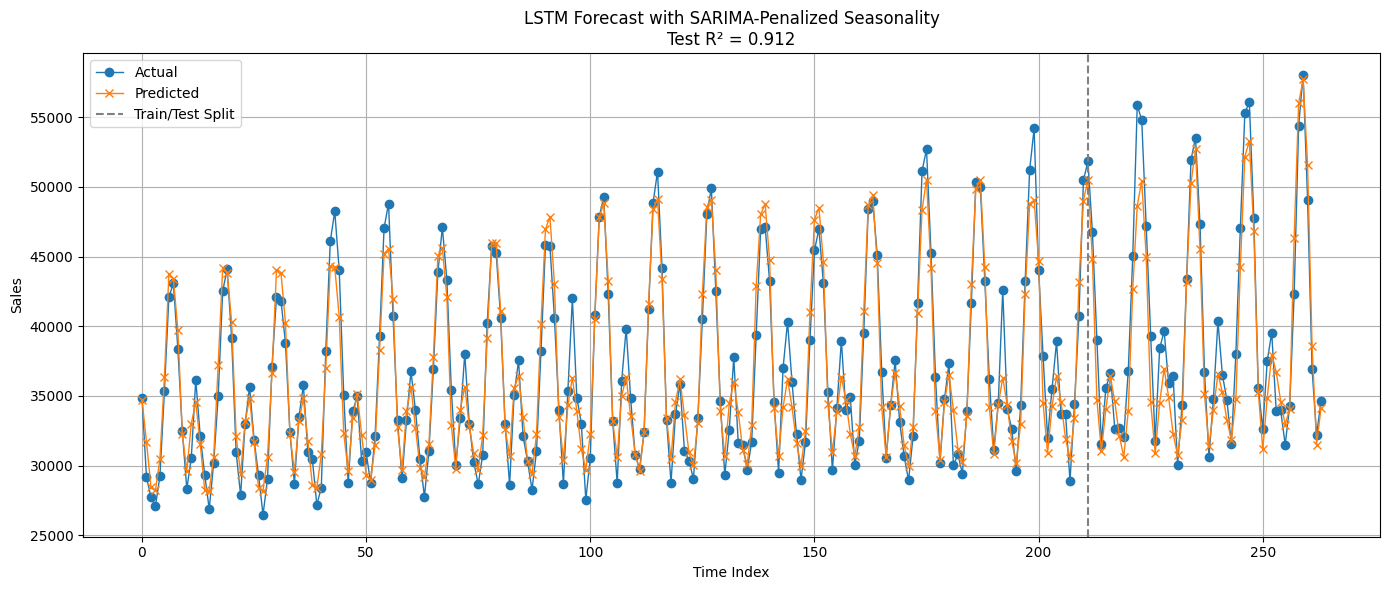

In [5]:
# LSTM Forecasting with SARIMA-Penalized Seasonality (Standalone Pipeline)

# -------------------------------
# Reproducibility Setup
# -------------------------------
import os
import random
import numpy as np
import tensorflow as tf

seed = 10011
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# -------------------------------
# Imports
# -------------------------------
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -------------------------------
# Load Dataset
# -------------------------------
df = pd.read_excel("energy_data_export.xlsx")
df['period'] = pd.to_datetime(df['period'])
df = df[df['sectorid'] == 'RES']

agg = df.groupby('period').agg({
    'sales': 'sum',
    'revenue': 'sum',
    'customers': 'sum',
    'price': 'mean'
}).reset_index()

# -------------------------------
# Feature Engineering
# -------------------------------
agg['month'] = agg['period'].dt.month
agg['avg_consumption'] = agg['sales'] / agg['customers']
agg['revenue_per_customer'] = agg['revenue'] / agg['customers']
agg['consumption_yoy'] = agg['avg_consumption'].pct_change(12) * 100
agg['customer_growth'] = agg['customers'].pct_change() * 100
agg['price_pct_change'] = agg['price'].pct_change()
agg['consumption_pct_change'] = agg['avg_consumption'].pct_change()
agg['price_elasticity'] = agg['consumption_pct_change'] / agg['price_pct_change']
agg['month_sin'] = np.sin(2 * np.pi * agg['month'] / 12)
agg['month_cos'] = np.cos(2 * np.pi * agg['month'] / 12)
agg['is_summer'] = agg['month'].isin([6, 7, 8, 9]).astype(int)

sigmoid = lambda x: 1 / (1 + np.exp(-x / 10))
agg['sarima_sigmoid'] = sigmoid(agg['consumption_yoy'].fillna(0))
agg['summer_weight'] = 1 + 0.2 * (agg['sarima_sigmoid'] - 0.5)
agg['summer_weight'] = np.clip(agg['summer_weight'], 0.9, 1.1)

agg.replace([np.inf, -np.inf], np.nan, inplace=True)
agg.fillna(method='ffill', inplace=True)
agg.fillna(method='bfill', inplace=True)

# -------------------------------
# Prepare Features and Target
# -------------------------------
features = ['price', 'avg_consumption', 'revenue_per_customer', 'consumption_yoy',
            'customer_growth', 'price_elasticity', 'month_sin', 'month_cos', 'is_summer']
target = 'sales'

X_df = agg[features].copy()
y = agg[target].values
summer_flag = agg['is_summer'].values
premium_multiplier = agg['summer_weight'].values

valid_idx = X_df.dropna().index
X_df = X_df.loc[valid_idx]
y = y[valid_idx]
summer_flag = summer_flag[valid_idx]
premium_multiplier = premium_multiplier[valid_idx]

# -------------------------------
# Scale Inputs
# -------------------------------
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_df)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# -------------------------------
# Sequence Builder
# -------------------------------
def build_sequences(X, y, summer, premium, window=12):
    X_seq, y_seq, s_flag, p_mult = [], [], [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
        s_flag.append(summer[i+window])
        p_mult.append(premium[i+window])
    return np.array(X_seq), np.array(y_seq), np.array(s_flag), np.array(p_mult)

X_seq, y_seq, summer_seq, premium_seq = build_sequences(X_scaled, y_scaled, summer_flag, premium_multiplier)

# -------------------------------
# Train/Test Split
# -------------------------------
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
summer_train = summer_seq[:split]
premium_train = premium_seq[:split]

# -------------------------------
# Sample Weights
# -------------------------------
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
summer_avg = y_train_actual[summer_train == 1].mean()
non_summer_avg = y_train_actual[summer_train == 0].mean()
summer_ratio = summer_avg / non_summer_avg
sample_weights = np.where(summer_train == 1, summer_ratio**2 * premium_train, 1.0)

# -------------------------------
# Build LSTM Model
# -------------------------------
model = Sequential([
    BatchNormalization(),
    LSTM(64, return_sequences=True, activation='relu'),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.005), loss='mse')
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5)
]

# -------------------------------
# Train Model
# -------------------------------
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    sample_weight=sample_weights,
    epochs=50,
    batch_size=4,
    callbacks=callbacks,
    verbose=0
)

# -------------------------------
# Predict and Evaluate
# -------------------------------
y_pred_train = model.predict(X_train).flatten()
y_pred_test = model.predict(X_test).flatten()

y_pred_train = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1)).flatten()
y_pred_test = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

full_actual = np.concatenate([y_train_actual, y_test_actual])
full_pred = np.concatenate([y_pred_train, y_pred_test])
r2_test = r2_score(y_test_actual, y_pred_test)
split_index = len(y_train_actual)

# -------------------------------
# Plot Results
# -------------------------------
plt.figure(figsize=(14, 6))
plt.plot(full_actual, label='Actual', color='tab:blue', marker='o', linewidth=1)
plt.plot(full_pred, label='Predicted', color='tab:orange', marker='x', linewidth=1)
plt.axvline(x=split_index, linestyle='--', color='gray', label='Train/Test Split')
plt.title(f"LSTM Forecast with SARIMA-Penalized Seasonality\nTest R² = {r2_test:.3f}")
plt.xlabel("Time Index")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
Test R²:   0.9117
MAE:       1922.91
RMSE:      2400.13
MAPE:      4.68%


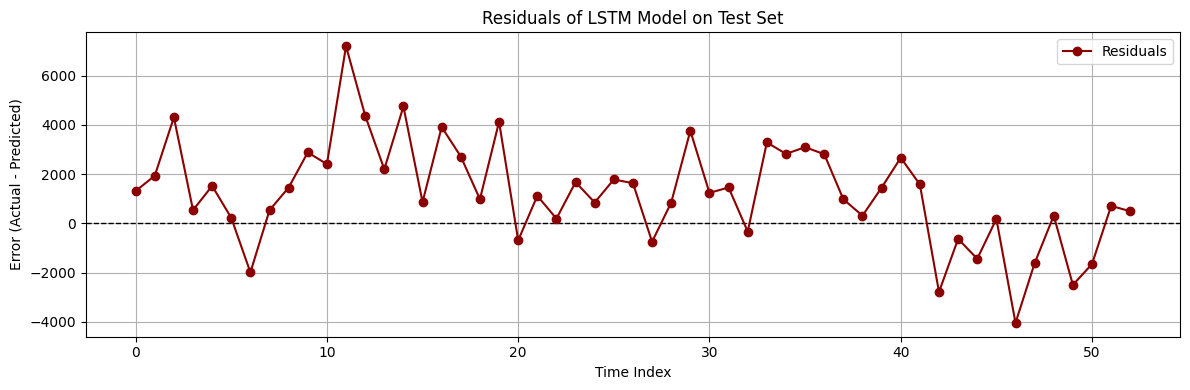

In [4]:
# LSTM Forecasting with SARIMA-Penalized Seasonality (with Full Metrics and Residual Plot)

# -------------------------------
# Reproducibility Setup
# -------------------------------
import os
import random
import numpy as np
import tensorflow as tf

SEED = 10011
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# -------------------------------
# Imports
# -------------------------------
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -------------------------------
# Load Dataset
# -------------------------------
df = pd.read_excel("energy_data_export.xlsx")
df['period'] = pd.to_datetime(df['period'])
df = df[df['sectorid'] == 'RES']

agg = df.groupby('period').agg({
    'sales': 'sum',
    'revenue': 'sum',
    'customers': 'sum',
    'price': 'mean'
}).reset_index()

# -------------------------------
# Feature Engineering
# -------------------------------
agg['month'] = agg['period'].dt.month
agg['avg_consumption'] = agg['sales'] / agg['customers']
agg['revenue_per_customer'] = agg['revenue'] / agg['customers']
agg['consumption_yoy'] = agg['avg_consumption'].pct_change(12) * 100
agg['customer_growth'] = agg['customers'].pct_change() * 100
agg['price_pct_change'] = agg['price'].pct_change()
agg['consumption_pct_change'] = agg['avg_consumption'].pct_change()
agg['price_elasticity'] = agg['consumption_pct_change'] / agg['price_pct_change']
agg['month_sin'] = np.sin(2 * np.pi * agg['month'] / 12)
agg['month_cos'] = np.cos(2 * np.pi * agg['month'] / 12)
agg['is_summer'] = agg['month'].isin([6, 7, 8, 9]).astype(int)

sigmoid = lambda x: 1 / (1 + np.exp(-x / 10))
agg['sarima_sigmoid'] = sigmoid(agg['consumption_yoy'].fillna(0))
agg['summer_weight'] = 1 + 0.2 * (agg['sarima_sigmoid'] - 0.5)
agg['summer_weight'] = np.clip(agg['summer_weight'], 0.9, 1.1)

agg.replace([np.inf, -np.inf], np.nan, inplace=True)
agg.ffill(inplace=True)
agg.bfill(inplace=True)

# -------------------------------
# Prepare Features and Target
# -------------------------------
features = ['price', 'avg_consumption', 'revenue_per_customer', 'consumption_yoy',
            'customer_growth', 'price_elasticity', 'month_sin', 'month_cos', 'is_summer']
target = 'sales'

X_df = agg[features].copy()
y = agg[target].values
summer_flag = agg['is_summer'].values
premium_multiplier = agg['summer_weight'].values

valid_idx = X_df.dropna().index
X_df = X_df.loc[valid_idx]
y = y[valid_idx]
summer_flag = summer_flag[valid_idx]
premium_multiplier = premium_multiplier[valid_idx]

# -------------------------------
# Scale Inputs
# -------------------------------
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_df)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# -------------------------------
# Sequence Builder
# -------------------------------
def build_sequences(X, y, summer, premium, window=12):
    X_seq, y_seq, s_flag, p_mult = [], [], [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
        s_flag.append(summer[i+window])
        p_mult.append(premium[i+window])
    return np.array(X_seq), np.array(y_seq), np.array(s_flag), np.array(p_mult)

X_seq, y_seq, summer_seq, premium_seq = build_sequences(X_scaled, y_scaled, summer_flag, premium_multiplier)

# -------------------------------
# Train/Test Split
# -------------------------------
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
summer_train = summer_seq[:split]
premium_train = premium_seq[:split]

# -------------------------------
# Sample Weights
# -------------------------------
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
summer_avg = y_train_actual[summer_train == 1].mean()
non_summer_avg = y_train_actual[summer_train == 0].mean()
summer_ratio = summer_avg / non_summer_avg
sample_weights = np.where(summer_train == 1, summer_ratio**2 * premium_train, 1.0)

# -------------------------------
# Build LSTM Model
# -------------------------------
model = Sequential([
    BatchNormalization(),
    LSTM(64, return_sequences=True, activation='relu'),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.005), loss='mse')
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5)
]

# -------------------------------
# Train Model
# -------------------------------
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    sample_weight=sample_weights,
    epochs=50,
    batch_size=4,
    callbacks=callbacks,
    verbose=0
)

# -------------------------------
# Predict and Evaluate
# -------------------------------
y_pred_test = model.predict(X_test).flatten()
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_test = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()

# Evaluation metrics
r2 = r2_score(y_test_actual, y_pred_test)
mae = mean_absolute_error(y_test_actual, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_test))
mape = np.mean(np.abs((y_test_actual - y_pred_test) / y_test_actual)) * 100

print(f"Test R²:   {r2:.4f}")
print(f"MAE:       {mae:.2f}")
print(f"RMSE:      {rmse:.2f}")
print(f"MAPE:      {mape:.2f}%")

# -------------------------------
# Residual Plot
# -------------------------------
residuals = y_test_actual - y_pred_test
plt.figure(figsize=(12, 4))
plt.axhline(0, linestyle='--', color='black', linewidth=1)
plt.plot(residuals, marker='o', linestyle='-', color='darkred', label='Residuals')
plt.title("Residuals of LSTM Model on Test Set")
plt.xlabel("Time Index")
plt.ylabel("Error (Actual - Predicted)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load your dataset
df = pd.read_excel("energy_data_export.xlsx")
df['period'] = pd.to_datetime(df['period'])
df = df[df['sectorid'] == 'RES']

# Precompute aggregation
def prepare_data(df):
    agg = df.groupby('period').agg({
        'sales': 'sum',
        'revenue': 'sum',
        'customers': 'sum',
        'price': 'mean'
    }).reset_index()

    agg['month'] = agg['period'].dt.month
    agg['avg_consumption'] = agg['sales'] / agg['customers']
    agg['revenue_per_customer'] = agg['revenue'] / agg['customers']
    agg['consumption_yoy'] = agg['avg_consumption'].pct_change(12) * 100
    agg['customer_growth'] = agg['customers'].pct_change() * 100
    agg['price_pct_change'] = agg['price'].pct_change()
    agg['consumption_pct_change'] = agg['avg_consumption'].pct_change()
    agg['price_elasticity'] = agg['consumption_pct_change'] / agg['price_pct_change']
    agg['month_sin'] = np.sin(2 * np.pi * agg['month'] / 12)
    agg['month_cos'] = np.cos(2 * np.pi * agg['month'] / 12)
    agg['is_summer'] = agg['month'].isin([6, 7, 8, 9]).astype(int)
    sigmoid = lambda x: 1 / (1 + np.exp(-x / 10))
    agg['sarima_sigmoid'] = sigmoid(agg['consumption_yoy'].fillna(0))
    agg['summer_weight'] = 1 + 0.2 * (agg['sarima_sigmoid'] - 0.5)
    agg['summer_weight'] = np.clip(agg['summer_weight'], 0.9, 1.1)
    agg.replace([np.inf, -np.inf], np.nan, inplace=True)
    agg.ffill(inplace=True)
    agg.bfill(inplace=True)
    return agg

# LSTM sequence builder
def build_sequences(X, y, summer, premium, window=12):
    X_seq, y_seq, s_flag, p_mult = [], [], [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
        s_flag.append(summer[i+window])
        p_mult.append(premium[i+window])
    return np.array(X_seq), np.array(y_seq), np.array(s_flag), np.array(p_mult)

# Seed test runner
def run_model_with_seed(seed, agg):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    features = ['price', 'avg_consumption', 'revenue_per_customer', 'consumption_yoy',
                'customer_growth', 'price_elasticity', 'month_sin', 'month_cos', 'is_summer']
    target = 'sales'
    X_df = agg[features].copy()
    y = agg[target].values
    summer_flag = agg['is_summer'].values
    premium_multiplier = agg['summer_weight'].values

    valid_idx = X_df.dropna().index
    X_df = X_df.loc[valid_idx]
    y = y[valid_idx]
    summer_flag = summer_flag[valid_idx]
    premium_multiplier = premium_multiplier[valid_idx]

    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X_df)
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
    X_seq, y_seq, summer_seq, premium_seq = build_sequences(X_scaled, y_scaled, summer_flag, premium_multiplier)

    split = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]
    summer_train = summer_seq[:split]
    premium_train = premium_seq[:split]

    y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
    summer_avg = y_train_actual[summer_train == 1].mean()
    non_summer_avg = y_train_actual[summer_train == 0].mean()
    summer_ratio = summer_avg / non_summer_avg
    sample_weights = np.where(summer_train == 1, summer_ratio**2 * premium_train, 1.0)

    model = Sequential([
        BatchNormalization(),
        LSTM(64, return_sequences=True, activation='relu'),
        Dropout(0.3),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.005), loss='mse')
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=2, factor=0.5)
    ]
    model.fit(X_train, y_train,
              validation_data=(X_test, y_test),
              sample_weight=sample_weights,
              epochs=50,
              batch_size=4,
              callbacks=callbacks,
              verbose=0)

    y_pred_test = model.predict(X_test).flatten()
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_test = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
    return r2_score(y_test_actual, y_pred_test)

# Run 30 times with random seeds
agg = prepare_data(df)
results = []
for _ in range(30):
    seed = random.randint(1, 999999)
    r2 = run_model_with_seed(seed, agg)
    results.append((seed, r2))

# Display results
results_df = pd.DataFrame(results, columns=["Seed", "R2_Score"])
print(results_df.sort_values("R2_Score", ascending=False))
print(f"\nAverage R² across 30 runs: {results_df['R2_Score'].mean():.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 489ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 411ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 773ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 487ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 420ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 478ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 876ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 394ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

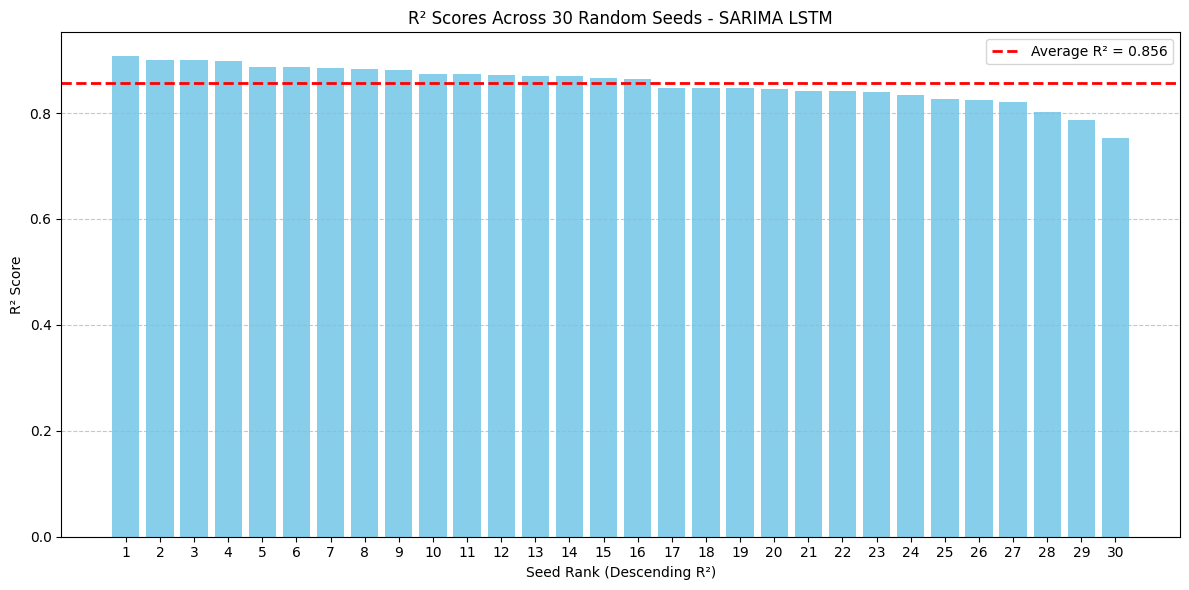

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Example data from SARIMA LSTM run (seed and R²)
sarima_r2_scores = [
    0.907079, 0.900366, 0.899460, 0.898084, 0.887863, 0.886379, 0.885028,
    0.882591, 0.881021, 0.873893, 0.873876, 0.872808, 0.870516, 0.869556,
    0.865919, 0.864696, 0.847595, 0.847067, 0.846958, 0.846274, 0.842397,
    0.842319, 0.839108, 0.834143, 0.826659, 0.825249, 0.820207, 0.802543,
    0.787659, 0.752934
]

# Sort for visual consistency
sarima_r2_sorted = sorted(sarima_r2_scores, reverse=True)
average_r2_sarima = np.mean(sarima_r2_sorted)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(1, 31), sarima_r2_sorted, color='skyblue')
plt.axhline(average_r2_sarima, color='red', linestyle='--', linewidth=2, label=f'Average R² = {average_r2_sarima:.3f}')
plt.title("R² Scores Across 30 Random Seeds - SARIMA LSTM")
plt.xlabel("Seed Rank (Descending R²)")
plt.ylabel("R² Score")
plt.xticks(ticks=range(1, 31))
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()
